In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
file_name = '/content/drive/My Drive/lsp_dataset.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()

# **Main Function**

---



---



Epoch: 1
............................	 Training Loss: 0.0178	 Validation Loss: 0.0143	 Total Time: 3.97 min

-------------------------------------------------------------------------------------
In PCKh@0.5 Evaluation Metric, The output Validation Accuracy for joints In Epoch 1:

The Accuracy For Ankle:   	0.43%
The Accuracy For Knee:    	0.14%
The Accuracy For Hip:     	0.00%
The Accuracy For Wrist:   	0.72%
The Accuracy For Elbow:   	0.29%
The Accuracy For Shoulder:	0.00%
The Accuracy For Head:     	0.29%


Epoch: 2
............................	 Training Loss: 0.0142	 Validation Loss: 0.0143	 Total Time: 3.92 min

-------------------------------------------------------------------------------------
In PCKh@0.5 Evaluation Metric, The output Validation Accuracy for joints In Epoch 2:

The Accuracy For Ankle:   	0.72%
The Accuracy For Knee:    	0.86%
The Accuracy For Hip:     	0.14%
The Accuracy For Wrist:   	0.86%
The Accuracy For Elbow:   	0.29%
The Accuracy For Shoulder:	0.14%
The Ac

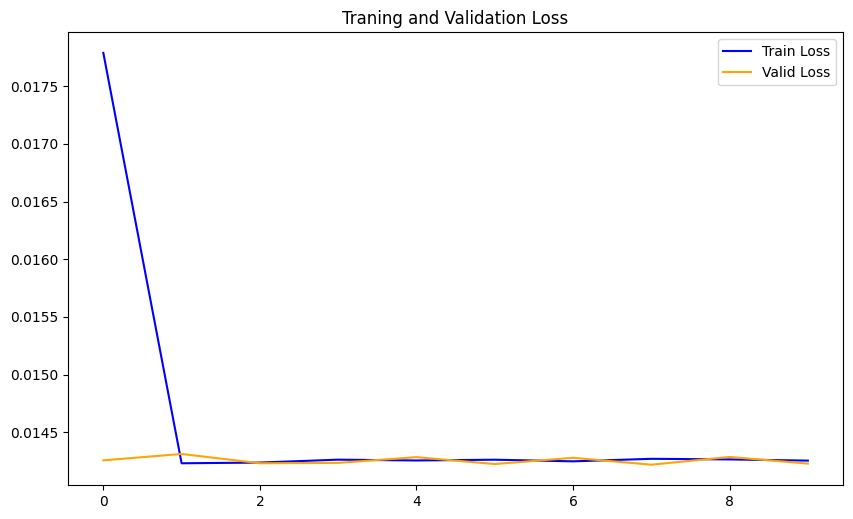

In [3]:
from models import Complete_Model, GaussianFilterLayer
from utils import Heatmaps_to_Joints, count_parameters
from train_test import train
from dataset import augment, transform_joints, resize_dataset, get_data_loaders
from torchvision import transforms
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

if __name__ == '__main__':
    joint_name = ['Ankle:   ',
                  'Knee:    ',
                  'Hip:     ',
                  'Wrist:   ',
                  'Elbow:   ',
                  'Shoulder:',
                  'Head:     ']

    images_folder = '/content/lsp_dataset/images/'
    joints_path = '/content/lsp_dataset/joints.mat'
    resize_shape = (256, 256)
    aug_prob = 0.2
    images_folder, joints_path = transform_joints(images_folder, joints_path, aug_prob=aug_prob, resize_shape=resize_shape) 
    
    num_joints = 14
    batch_size = 12
    epoches = 10

    custom_trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,))])
    cuda_flag = True if torch.cuda.is_available() else False
    seed = 12568
    device = torch.device('cuda' if cuda_flag else 'cpu')
    if seed:
        torch.manual_seed(seed)
    params = {'num_workers': 0, 'pin_memory': True} if cuda_flag else {}
    data_paths = [images_folder, joints_path]
    data_splits = [0.70, 0.15, 0.15]
    batch_sizes = [batch_size, batch_size, batch_size]
    train_loader, valid_loader, test_loader = get_data_loaders(data_paths, data_splits, batch_sizes, shuffle_images=False,
                                                              seed=56238, transform=custom_trans, **params)
    

    # model = Complete_Model(64, batch_size, 14).to(device)
    model = Complete_Model(64, batch_size, 4, 14).to(device)
    g_model = GaussianFilterLayer(14, 21, 3, 14).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

    joint_detection = Heatmaps_to_Joints()

    train_loss, valid_loss, PCKh_valid_accuracy = train(model, g_model, criterion, optimizer, train_loader, valid_loader,
                                                        epoches, device, scheduler, batch_size, joint_detection, joint_name)


    ######################################################################################
    plt.figure(figsize=(10,6), dpi=100)
    plt.title('Traning and Validation Loss')
    plt.plot(train_loss, color='blue', label='Train Loss')
    plt.plot(valid_loss, color='orange', label='Valid Loss')
    plt.legend()
    plt.savefig('/content/drive/My Drive/Colab Projects/Final Projects/Loss_Plot.jpg', dpi=200)
    plt.show()


In [ ]:
images = draw_pose(model, test_loader, 4)